In [1]:
import os
import sys
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from dataclasses import dataclass

In [2]:
module_path = os.path.abspath("../")
sys.path.append(module_path) #add parent directory to path to detect the modules

In [3]:
from ift6758.data import NHL
from ift6758.data import clean_data
from ift6758.feature import extract_features
from ift6758.model import process_feats
from ift6758.model import scale_data
from ift6758.model import fit_pca
from ift6758.model import balanced_dataset
from ift6758.model import feature_selection
from ift6758.model import get_model
from ift6758.model import train
from ift6758.viz import plot_roc_curves


In [4]:
data_path = os.getcwd()

In [5]:
def get_train_test_data():
    
    # For training
    nhl = NHL(2015, 2019, path = data_path)
    
    event_types = ['SHOT', 'GOAL'] #relevant type of events.
    train_df = nhl.to_DataFrame_optimized(event_types, game_types = ['02'])

    # Clean data
    train_c_df = clean_data(train_df)
    
    # Feature extraction
    train_r_df = extract_features(train_c_df)

    train_new_df = process_feats(train_r_df)
    
    train_new_df['game_seconds'] = train_new_df['game_seconds'] / 60
    
    # For testing
    nhl = NHL(2020, path = data_path) # for just one year
    
    event_types = ['SHOT', 'GOAL'] #relevant type of events.
    test_df = nhl.to_DataFrame_optimized(event_types, game_types = ['02'])

    # Clean data
    test_c_df = clean_data(test_df)
    
    # Feature extraction
    test_r_df = extract_features(test_c_df)
    
    test_new_df = process_feats(test_r_df)
    
    test_new_df['game_seconds'] = test_new_df['game_seconds'] / 60
    
    # For playoff
    nhl = NHL(2020, path = data_path) # for just one year

    event_types = ['SHOT', 'GOAL'] #relevant type of events.
    test_df_playoff = nhl.to_DataFrame_optimized(event_types, game_types = ['03'])

    # Clean data
    test_c_df_playoff = clean_data(test_df_playoff)
    
    # Feature extraction
    test_r_df_playoff = extract_features(test_c_df_playoff)
    
    test_new_df_playoff = process_feats(test_r_df_playoff)
    
    test_new_df_playoff['game_seconds'] = test_new_df_playoff['game_seconds'] / 60
    
    return train_new_df, test_new_df, test_new_df_playoff
    


In [6]:
def preprocessing():
    
    df_train, df_test, df_test_playoff = get_train_test_data()
    df_train_l = df_train.copy(deep=True)
    df_test_l = df_test.copy(deep=True)
    df_test_playoff_l = df_test_playoff.copy(deep=True)
    print(len(df_test_l))
    
    label_train = df_train[['event_type']]
    label_train = np.array(label_train).ravel()
    
    df_train = df_train.drop(columns=['event_type'])
    
    X_train, X_val, y_train, y_val = train_test_split(df_train, label_train, test_size=0.1)
    
    label_test = df_test[['event_type']]
    label_test = np.array(label_test).ravel()
    
    df_test = df_test.drop(columns=['event_type'])
    print(len(df_test), len(df_test_l))
    
    # For playoff
    label_test_playoff = df_test_playoff[['event_type']]
    label_test_playoff = np.array(label_test_playoff).ravel()
    
    df_test_playoff = df_test_playoff.drop(columns=['event_type'])
        
    return df_train, label_train, df_test, label_test, X_train, X_val, y_train, y_val, df_test_playoff, label_test_playoff, df_train_l, df_test_l, df_test_playoff_l
        

In [13]:
feats_train, label_train, feats_test, label_test, X_train, X_val, y_train, y_val, feats_test_playoff, label_test_playoff, df_train_l, df_test_l, df_test_playoff_l = preprocessing()


Loading 2015-2016 regular season data...
Load success!
Processing games...


100%|██████████████████████████████████████| 1230/1230 [00:02<00:00, 555.85it/s]


Loading 2016-2017 regular season data...
Load success!
Processing games...


100%|█████████████████████████████████████| 1230/1230 [00:00<00:00, 1434.40it/s]


Loading 2017-2018 regular season data...
Load success!
Processing games...


100%|█████████████████████████████████████| 1271/1271 [00:00<00:00, 1376.38it/s]


Loading 2018-2019 regular season data...
Load success!
Processing games...


100%|█████████████████████████████████████| 1271/1271 [00:00<00:00, 1352.88it/s]


Loading 2019-2020 regular season data...
Load success!
Processing games...


100%|██████████████████████████████████████| 1271/1271 [00:02<00:00, 558.19it/s]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Loading 2020-2021 regular season data...
Load success!
Processing games...


100%|███████████████████████████████████████| 868/868 [00:00<00:00, 1414.00it/s]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Loading 2020-2021 playoff season data...
Load success!
Processing games...


100%|███████████████████████████████████████| 105/105 [00:00<00:00, 1517.75it/s]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


52033
52033 52033


In [8]:
@dataclass
class Arguments:
    # Model -> [xgboost, random_forest, cat_boost, gradient_boosting, hist_gradient_boosting, mlp]
    model: str = 'random_forest'
        
    # Feature -> [default, extra, importance, mutual_info, pca]
    feature: str = 'default'
        
    num_features: int = 10
    
    # Smoothing -> [True, False]
    smoothing: bool = False
        
    k_neighbors: int = 3
        
    # Mode -> [default, tune, best]
    mode: str = 'best'
        
    selection_mode: bool = False
        
    num_feature: int = 10
        
    hidden_layer: int = 50
        
    max_depth: int = 40
    
    min_samples_leaf: int = 50
        
    learning_rate: float = 0.1
        
    alpha: float = 0.0001


In [9]:
configs = {
    # 0.76
    1: Arguments(model='random_forest', feature='default', mode='best', max_depth=40, min_samples_leaf=50),
    # 0.777
    2: Arguments(model='random_forest', feature='extra', mode='best', max_depth=40, min_samples_leaf=50),
    # 0.76
    3: Arguments(model='random_forest', feature='mutual_info', num_features=10, mode='best', max_depth=40, min_samples_leaf=50),

    # 0.75
    4: Arguments(model='mlp', feature='extra', mode='default', hidden_layer=50),
    # 0.76
    5: Arguments(model='mlp', feature='extra', mode='default', hidden_layer=100),
    # 0.76
    6: Arguments(model='mlp', feature='extra', mode='default', hidden_layer=150),
    # 0.74
    7: Arguments(model='mlp', feature='extra', smoothing=True, k_neighbors=4, mode='default', hidden_layer=100),
    # 0.76
    8: Arguments(model='mlp', feature='pca', mode='default', hidden_layer=100),

    # 0.77
    9: Arguments(model='gradient_boosting', feature='default', mode='best', learning_rate=0.6),
    # 0.77
    10: Arguments(model='gradient_boosting', feature='extra', mode='best', learning_rate=0.6),
    # 0.76
    11: Arguments(model='gradient_boosting', feature='extra', smoothing=True, k_neighbors=3, mode='best', learning_rate=0.6),
    
    # 0.78
    12: Arguments(model='cat_boost', feature='default', mode='best', learning_rate=0.16),
    # 0.78
    13: Arguments(model='cat_boost', feature='extra', mode='best', learning_rate=0.16),
    # 0.77
    14: Arguments(model='cat_boost', feature='extra', smoothing=True, k_neighbors=3, mode='best', learning_rate=0.2),
    # 0.78
    15: Arguments(model='cat_boost', feature='importance', mode='tune', selection_mode=True, learning_rate=0.2),
    
    16: Arguments(model='hist_gradient_boosting', feature='extra', smoothing=True, k_neighbors=4, mode='tune'),
    
    17: Arguments(model='hist_gradient_boosting', feature='default', mode='default'),
    
    18: Arguments(model='hist_gradient_boosting', feature='default', smoothing=True, k_neighbors=4, mode='best'),
    
    19: Arguments(model='hist_gradient_boosting', feature='extra', smoothing=True, k_neighbors=4, mode='best'),
    
    20: Arguments(model='hist_gradient_boosting', feature='extra', mode='best'),
    
    21: Arguments(model='hist_gradient_boosting', feature='default', smoothing=True, k_neighbors=4),
    
    22: Arguments(model='xgboost', feature='default')

}

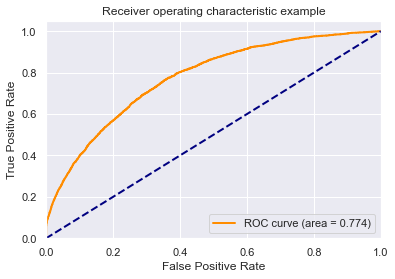

X has feature names, but RandomForestClassifier was fitted without feature names


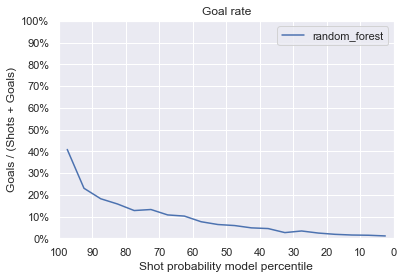

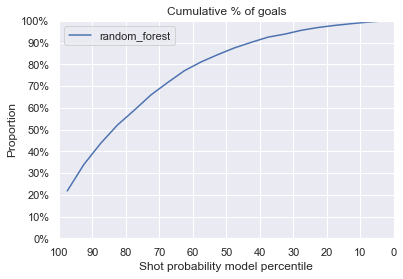

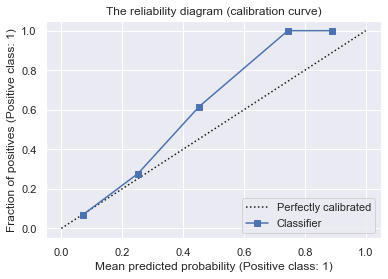

In [17]:
args = configs[2]
model, roc_auc, preds = train(X_train, y_train, X_val, y_val, args)
y_pred = model.predict(X_val)
f1 = f1_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)


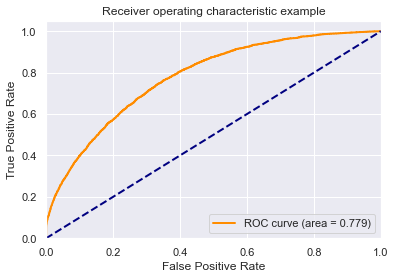

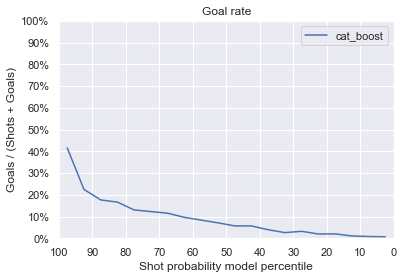

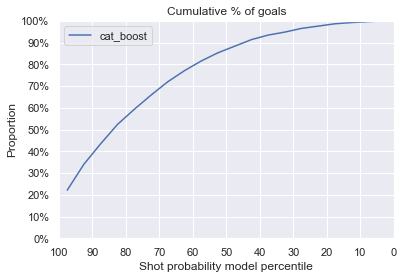

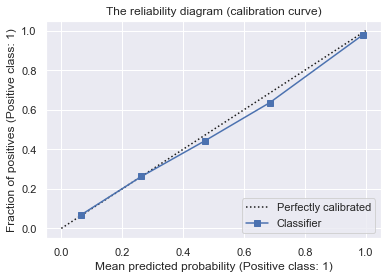

In [18]:
args = configs[13]
model, roc_auc, preds = train(X_train, y_train, X_val, y_val, args)
y_pred = model.predict(X_val)
f1 = f1_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)


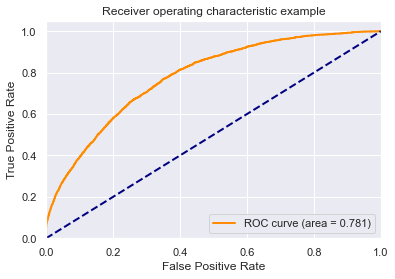

X has feature names, but HistGradientBoostingClassifier was fitted without feature names


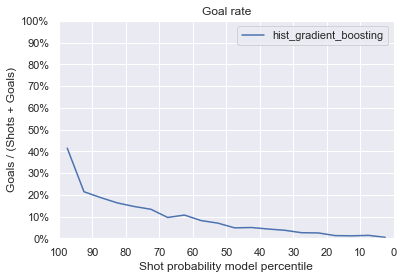

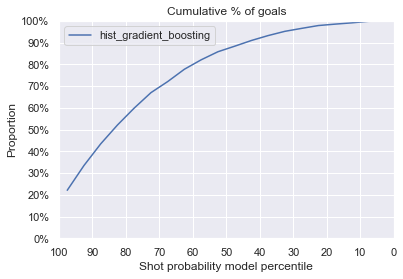

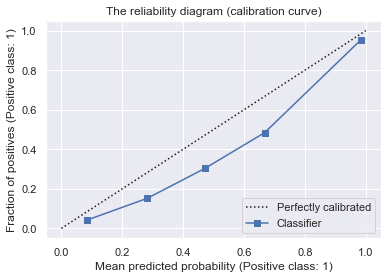

In [19]:
args = configs[21]
model, roc_auc, preds = train(X_train, y_train, X_val, y_val, args)
y_pred = model.predict(X_val)
f1 = f1_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)


In [ ]:
from ift6758.utils import Comet

comet = Comet()

comet.log_model(model,'Hist_Gradient_Boosting', data_path)

comet.log_metrics({"auc": roc_auc})
comet.log_metrics({"accuracy_score": accuracy})
comet.log_metrics({"f1_score": f1})


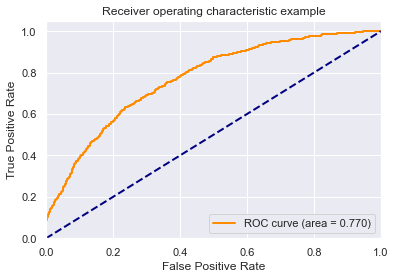

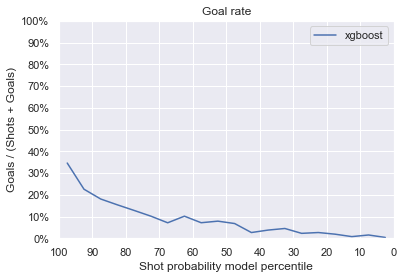

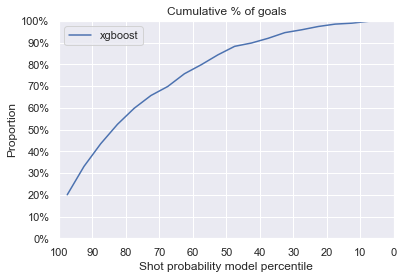

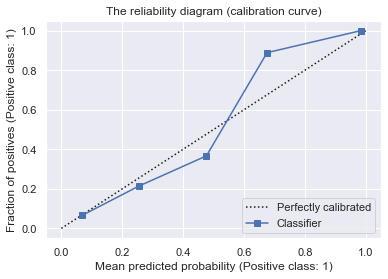

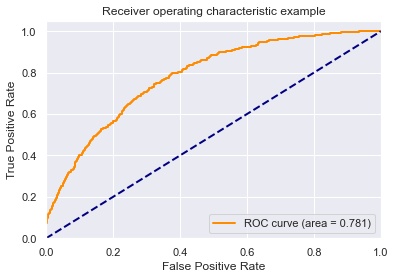

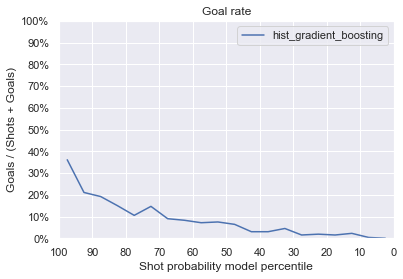

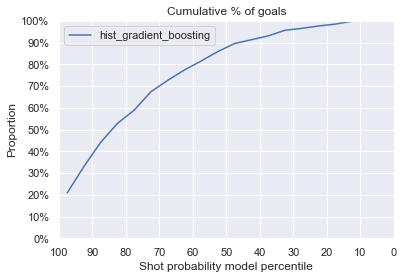

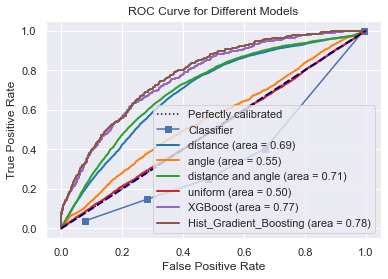

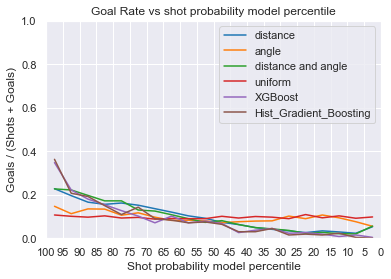

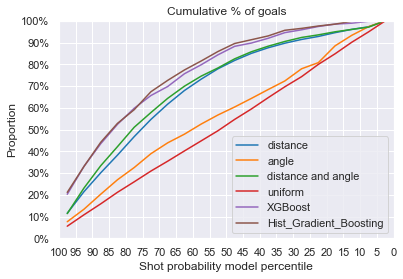

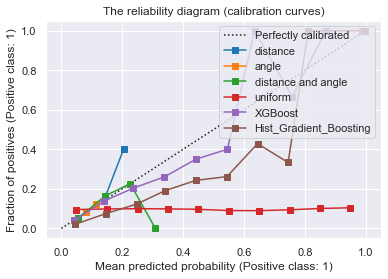

In [20]:
from ift6758.model import *

feat_list = ['game_seconds', 'period', 'coord_x', 'coord_y', 'shot_distance', 'shot_angle', 'shot_type', 'prev_event_type', 'prev_coord_x', 'prev_coord_y', 
            'time_from_prev_event', 'distance_from_prev_event', 'rebound', 'change_in_angle', 'speed', 'empty_net', 'event_type']

train_df = df_train_l[feat_list]
test_df = df_test_l[feat_list]

models, res = train_base_models(train_df)
results = test_base_models(models, test_df)

args = configs[22]
model, roc_auc, preds = train(feats_train, label_train, feats_test_playoff, label_test_playoff, args)
results.append(preds)

args = configs[21]
model, roc_auc, preds = train(feats_train, label_train, feats_test_playoff, label_test_playoff, args)
results.append(preds)

labels = ['distance', 'angle', 'distance and angle', 'uniform', 'XGBoost', 'Hist_Gradient_Boosting']

plot_roc_curves(results, labels = labels, title = 'ROC Curve for Different Models')
plot_goal_rate(results, labels = labels)
plot_cum_goal_percentages(results, labels = labels)
plot_calibration_curves(results, labels = labels)


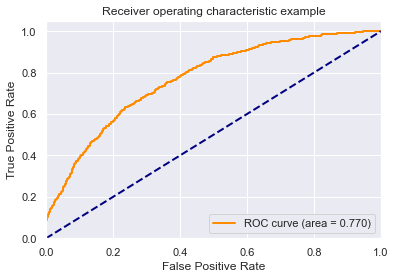

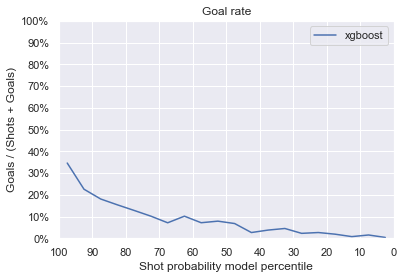

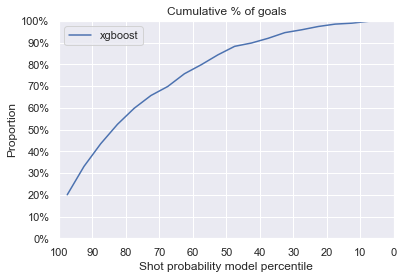

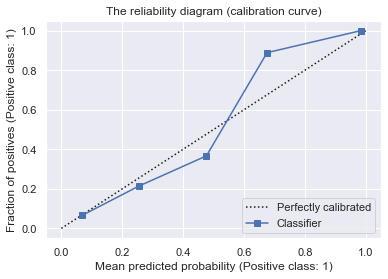

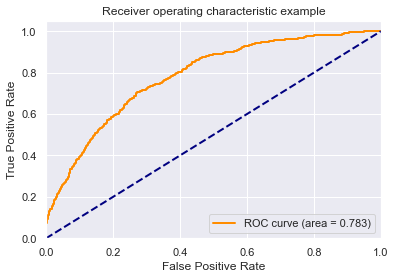

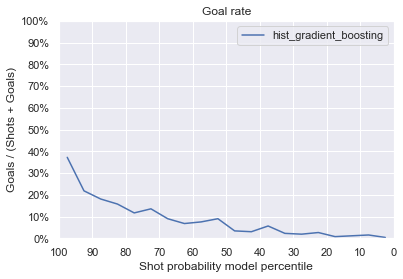

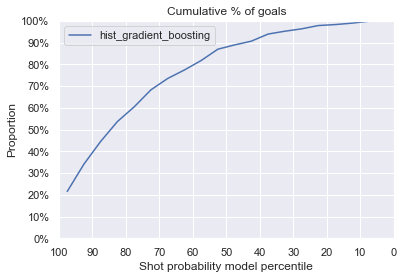

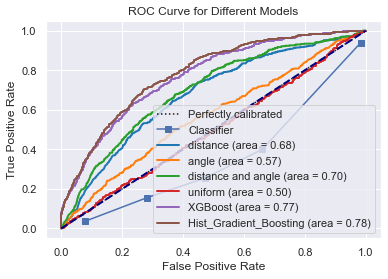

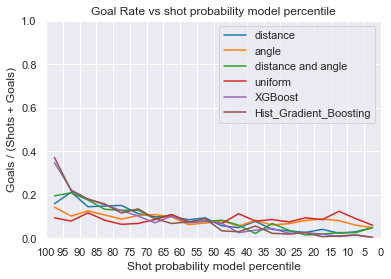

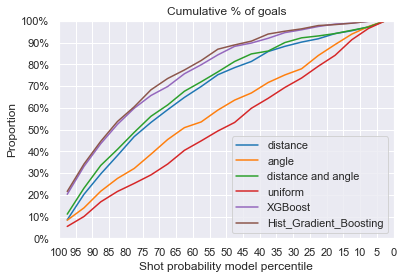

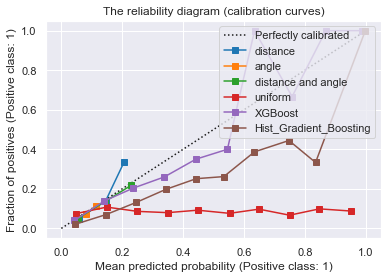

In [21]:
from ift6758.model import *

feat_list = ['game_seconds', 'period', 'coord_x', 'coord_y', 'shot_distance', 'shot_angle', 'shot_type', 'prev_event_type', 'prev_coord_x', 'prev_coord_y', 
            'time_from_prev_event', 'distance_from_prev_event', 'rebound', 'change_in_angle', 'speed', 'empty_net', 'event_type']

train_df = df_train_l[feat_list]
test_df = df_test_playoff_l[feat_list]

models, res = train_base_models(train_df)
results = test_base_models(models, test_df)

args = configs[22]
model, roc_auc, preds = train(feats_train, label_train, feats_test_playoff, label_test_playoff, args)
results.append(preds)

args = configs[21]
model, roc_auc, preds = train(feats_train, label_train, feats_test_playoff, label_test_playoff, args)
results.append(preds)

labels = ['distance', 'angle', 'distance and angle', 'uniform', 'XGBoost', 'Hist_Gradient_Boosting']

plot_roc_curves(results, labels = labels, title = 'ROC Curve for Different Models')
plot_goal_rate(results, labels = labels)
plot_cum_goal_percentages(results, labels = labels)
plot_calibration_curves(results, labels = labels)
